# Using Sea Surface Temperature and Sea Surface Height Data for Hurricane Helene

#### Author: Julie Sanchez, NASA PO.DAAC

## Summary:
Here we show how to plot sea surface temperature (SST) and sea surface height (SSH) data for Hurricane Helene in September 2024 using Python packages. 

## Requirements:

1. Compute environment - This tutorial can be run on your **local compute environment** e.g. laptop, server

2. Earthdata Login - An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

## Datasets:

- **NASA Sea Surface Temperature data**, MUR [https://podaac.jpl.nasa.gov/MEaSUREs-MUR](https://podaac.jpl.nasa.gov/MEaSUREs-MUR) 
- **NASA Sea Surface Height data** [https://podaac.jpl.nasa.gov/NASA-SSH](https://podaac.jpl.nasa.gov/NASA-SSH)

## Learning Objectives:

- Use python to plot the SST and SSH in the Gulf of Mexico to show how Hurricane Helene impacted the region.
- Use `earthaccess` Python package to search for NASA data

### Import packages

In [1]:
#Import needed packages 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import numpy as np

### Authenticate
Authenticate your Earthdata Login (EDL) information using the earthaccess python package as follows:

In [2]:
auth = earthaccess.login(persist=True) # Login with your EDL credentials if asked

### Use `earthaccess` to search for data

In [3]:
# Information for MUR SST data in the specified range:
results_SST = earthaccess.search_data(
    short_name="MUR25-JPL-L4-GLOB-v04.2",
    temporal=("2024-09-23", "2024-09-27"),
    )
#results_SST

Granules found: 5


### Download 

Download files from September 23rd and 27th, 2024 for comparison.

In [5]:
earthaccess.download(results_SST[0], "../datasets/data_downloads/Helene/")
earthaccess.download(results_SST[4], "../datasets/data_downloads/Helene/")

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

 Getting 1 granules, approx download size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['..\\datasets\\data_downloads\\Helene\\20240927090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc']

The NASA-SSH dataset used in this notebook was created and gridded via the following method from Sentinel-6 data: [https://github.com/kevinmarlis/simple-gridder](https://github.com/kevinmarlis/simple-gridder). Here we host a sample file that can be accessed via our GitHub repository.

In [5]:
file_path_ssha = './Data/NASA-SSH_alt_ref_simple_grid_v1_20240923.nc'

In [6]:
# Search for datasets for different dates
file_path_sept_23 = '../datasets/data_downloads/Helene/20240923090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc'
file_path_sept_27 = '../datasets/data_downloads/Helene/20240927090000-JPL-L4_GHRSST-SSTfnd-MUR25-GLOB-v02.0-fv04.2.nc'

ds_sept_23 = xr.open_dataset(file_path_sept_23)
ds_sept_27 = xr.open_dataset(file_path_sept_27)
ds_ssha = xr.open_dataset(file_path_ssha)

# Extract SST data and convert to Celsius
sst_sept_23 = ds_sept_23['analysed_sst'].isel(time=0) - 273.15 
sst_sept_27 = ds_sept_27['analysed_sst'].isel(time=0) - 273.15 

# Ensure that both datasets are on the same grid
sst_sept_23, sst_sept_27 = xr.align(sst_sept_23, sst_sept_27, join='inner')

# Calculate SST difference between Sept 27 and Sept 23
sst_difference = sst_sept_27 - sst_sept_23

### Define plotting function

In [8]:
# Common function to plot SST, anomalies, SSHA, or differences along with hurricane tracks
def plot_with_tracks(data, title, vmin=None, vmax=None, cmap='RdBu_r', extent=[-100, -80, 17, 31], land_color='#8B4513', marker_color='red', cbar_label='(°C)'):
    # Check if the data contains valid numeric values
    if data.isnull().all():
        print(f"Warning: The data for {title} contains only NaN or missing values.")
        return

    # Plot the data if it contains valid numeric entries
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set custom zoom extent
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Add a filled land feature with darker brown color
    land = cfeature.NaturalEarthFeature('physical', 'land', '50m', facecolor=land_color)
    ax.add_feature(land)

    # Plot the data
    data = data.fillna(0)  # Fill NaN values with 0 or other reasonable value
    plot = data.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap, 
                     cbar_kwargs={'label': cbar_label})  # Unit on the colorbar

    # Add coastlines, gridlines, and labels
    ax.coastlines(resolution='50m', color='black', linewidth=1)
     # Add coastlines, gridlines, and labels
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    
    # Customize gridlines 
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False  # No latitude labels on the right side
    gl.top_labels = False  # No top labels

    # Add country borders and region outlines
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

    # Hurricane Helene track data
    hurricane_data = [
        ('SEP23', 25.0, 17.64, -82.02, 'Tropical Depression', 5),
        ('SEP24', 34.0, 18.84, -83.11, 'Tropical Storm', 7),
        ('SEP25', 65.0, 21.73, -86.33, 'Category 1', 9),
        ('SEP26', 82.2, 24.06, -86.27, 'Category 2', 11),
        ('SEP26', 99.6, 24.86, -85.43, 'Category 3', 13),
        ('SEP26', 115.0, 26.59, -84.89, 'Category 4', 15),
        ('SEP27', 137.4, 29.89, -83.73, 'Category 4', 15),
    ]

    # Plot hurricane track markers
    for i, (day, knts, lat, lon, category, marker_size) in enumerate(hurricane_data):
        ax.plot(lon, lat, marker='o', markersize=marker_size, color=marker_color, transform=ccrs.PlateCarree())
        
        # Only add the day label when it changes to avoid repetition
        if i == 0 or hurricane_data[i-1][0] != day:
            ax.text(lon + 0.2, lat - 0.3, day, transform=ccrs.PlateCarree(), fontsize=7, fontweight='bold', color='black')

    # Ensure the legend marker sizes match the track marker sizes
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Tropical Depression', markerfacecolor=marker_color, markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Tropical Storm', markerfacecolor=marker_color, markersize=7),
        Line2D([0], [0], marker='o', color='w', label='Category 1', markerfacecolor=marker_color, markersize=9),
        Line2D([0], [0], marker='o', color='w', label='Category 2', markerfacecolor=marker_color, markersize=11),
        Line2D([0], [0], marker='o', color='w', label='Category 3', markerfacecolor=marker_color, markersize=13),
        Line2D([0], [0], marker='o', color='w', label='Category 4', markerfacecolor=marker_color, markersize=15),
    ]
    ax.legend(handles=legend_elements, loc='upper left', title="Hurricane Intensity", frameon=True)

    # Add map title
    plt.title(title)

    # Show the plot
    plt.show()


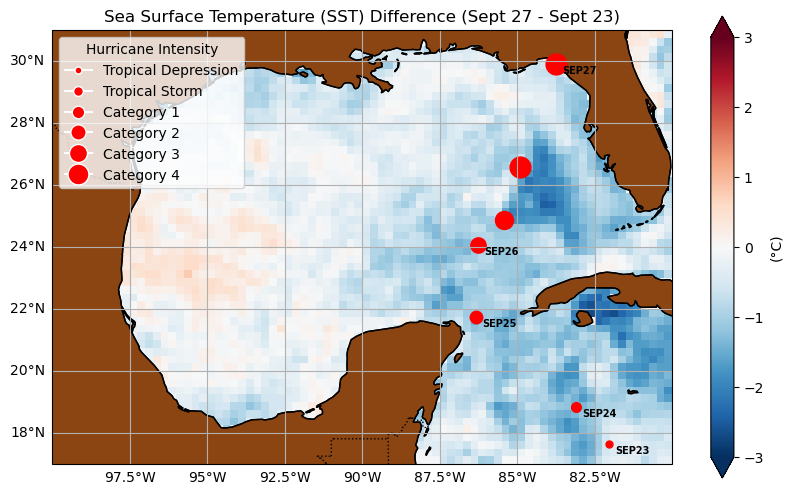

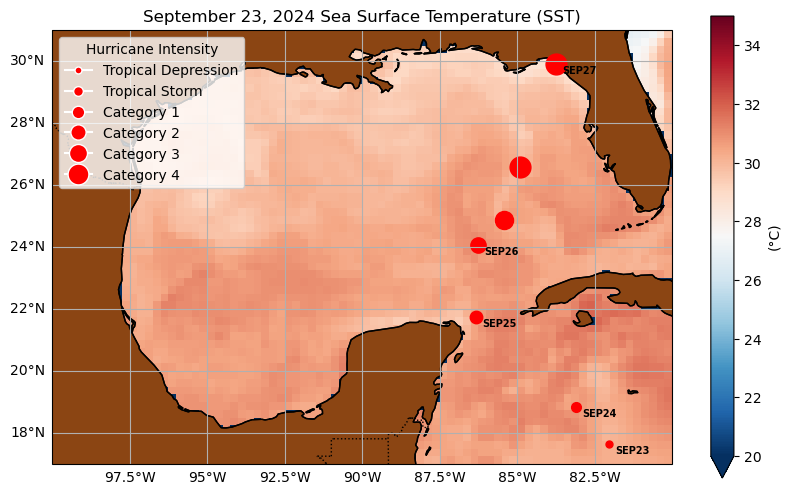

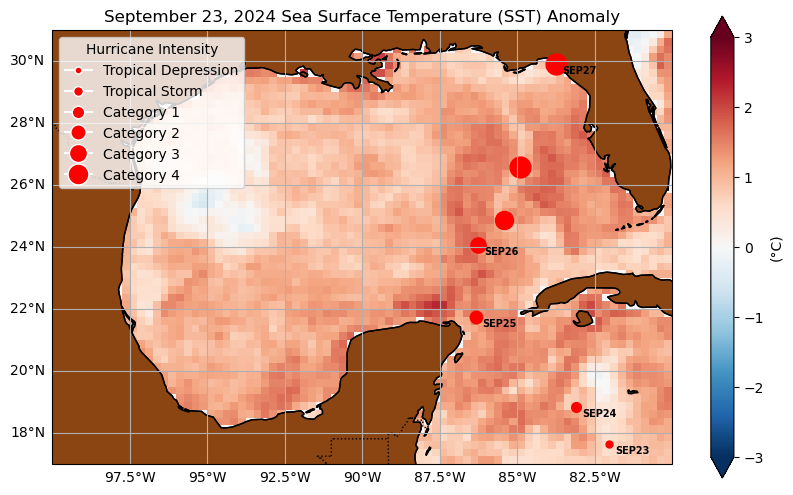

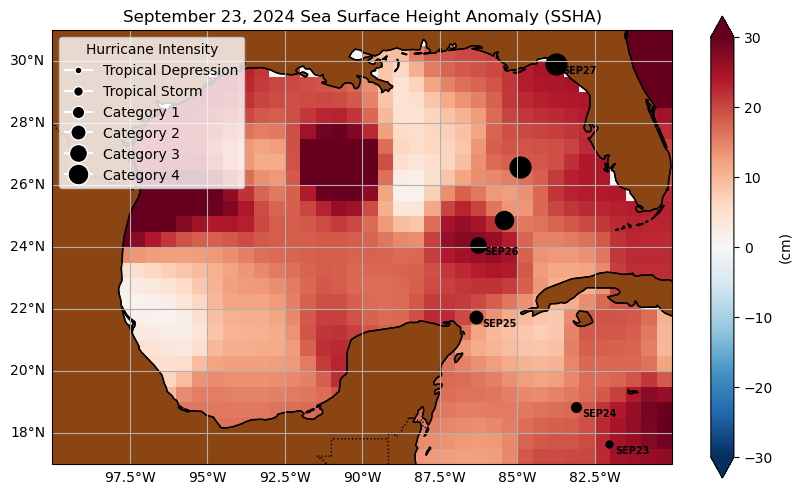

In [11]:
# Plot SST difference
plot_with_tracks(sst_difference, title='Sea Surface Temperature (SST) Difference (Sept 27 - Sept 23)', vmin=-3, vmax=3, marker_color='red')

# Plot SST for September 23
plot_with_tracks(sst_sept_23, title='September 23, 2024 Sea Surface Temperature (SST)', vmin=20, vmax=35, marker_color='red')

# Plot SST anomaly if available
if 'sst_anomaly' in ds_sept_23.variables:
    sst_anomaly = ds_sept_23['sst_anomaly'].isel(time=0)
    plot_with_tracks(sst_anomaly, title='September 23, 2024 Sea Surface Temperature (SST) Anomaly', vmin=-3, vmax=3, marker_color='red')

# Extract the SSHA variable (no time indexing needed)
ssha = ds_ssha['SSHA'] * 100  # Convert from meters to centimeters

# Mask out invalid values (NaN values)
ssha = ssha.where(~ssha.isnull(), other=np.nan)

# Plot SSHA with the same extent and color scheme, including hurricane tracks
plot_with_tracks(ssha, title='September 23, 2024 Sea Surface Height Anomaly (SSHA)', vmin=-30, vmax=30, marker_color='black', cbar_label='(cm)')
